In [24]:
# 1. Import the following libraries: 
# pip install pandas numpy matplotlib statsmodels scikit-learn

# pandas (for data manipulation)
import pandas as pd
    
# numpy (for numerical operations)
import numpy as np
    
# matplotlib (for data visualization)
import matplotlib.pyplot as plt 
    
# statsmodels (to use ARIMA)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scikit-learn (for error metrics)
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Importing stock data using AlphaVantage API

# !pip install alpha_vantage

from alpha_vantage.timeseries import TimeSeries

#Free API key
key = 'UO4WWNLT3XIKJ6EI'

# Create TimeSeries object
ts = TimeSeries(key, output_format='pandas') #requires input of key and output format (default is json)

# Sample API Call for Tesla
#objects come with a data and a meta component (will likely only need data component), require a stock symbol + interval + output size
data, meta = ts.get_intraday('TSLA', interval = '1min', outputsize='full')

In [3]:
# 3. Modify the dataset

# Keep relevant columns - closing price and date
closing_data = data['4. close']

In [4]:
# 4. Separate the data into training and testing datasets

# Create a DataFrame using the closing price data
df = pd.DataFrame(closing_data)

print(df)

# Split data into 70-30 training-testing data sets
# Sort df by ascending order (most recent date comes last)
df.sort_index(ascending=True, inplace=True)

print(df)

# train_size represents the first 70% of all rows; use this index to slice the data
train_size = int(len(df) * 0.7)

# Training data will include all rows starting from the first row up to the row indicated by 'train_size'
train_data = df.iloc[:train_size]
# The rest 30% will be included in testing data
test_data = df.iloc[train_size:]

print("Training data: ", train_data)
print("Testing data: ", test_data)

                     4. close
date                         
2024-01-12 19:59:00    218.99
2024-01-12 19:58:00    218.86
2024-01-12 19:57:00    218.79
2024-01-12 19:56:00    218.80
2024-01-12 19:55:00    218.78
...                       ...
2023-12-26 04:04:00    254.31
2023-12-26 04:03:00    254.37
2023-12-26 04:02:00    254.38
2023-12-26 04:01:00    254.10
2023-12-26 04:00:00    253.88

[12479 rows x 1 columns]
                     4. close
date                         
2023-12-26 04:00:00    253.88
2023-12-26 04:01:00    254.10
2023-12-26 04:02:00    254.38
2023-12-26 04:03:00    254.37
2023-12-26 04:04:00    254.31
...                       ...
2024-01-12 19:55:00    218.78
2024-01-12 19:56:00    218.80
2024-01-12 19:57:00    218.79
2024-01-12 19:58:00    218.86
2024-01-12 19:59:00    218.99

[12479 rows x 1 columns]
Training data:                       4. close
date                         
2023-12-26 04:00:00    253.88
2023-12-26 04:01:00    254.10
2023-12-26 04:02:00    254.38
20

<AxesSubplot:xlabel='date'>

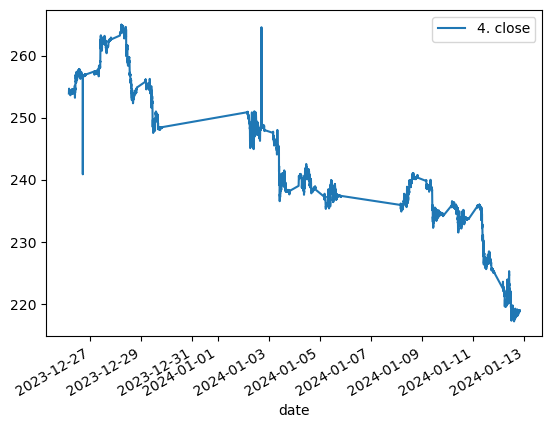

In [5]:
# 5.1 Visualize the data

# Plot the data for visualization
df.plot()

In [6]:
# 5.2 Conduct the ADF test and determine the value for d 

# Conduct the ADF test, which determines if the data is stationary or not
result = adfuller(df)

# Keeps track of the number of times differencing was needed 
d = 0

# If the data is not stationary, differencing is needed to convert it into stationary data
# The p-value has to be less than 0.05 for the dataset to be considered stationary 
while True:
    print('p-value: ', result[1])
    if result[1] < 0.05:
        break
    else:
        result = adfuller(df.diff().dropna())
        d += 1

print('\nd value: ', d)

p-value:  0.9646148789802648
p-value:  0.0

d value:  1


In [105]:
# 6. Optimize the parameters (p, d, q) and create the ARIMA model

    # Determine (p,d,q) based on the data's characteristics
    # ACF plot is used to determine p (autoregressive AR)
    # PACF plot is used to determine q (moving average MA)
    
    # Create the ARIMA model object and fit it to the data
    
    # Examples of useful python code:
    # p, d, q = 1, 1, 1
    # model = ARIMA(data, order(p,d,q))
    # model_fit = model.fit()

              4. close
date                  
2023-12-26  255.831750
2023-12-27  260.512458
2023-12-28  259.021306
2023-12-29  251.297274
2024-01-02  248.388308
2024-01-03  241.392159
2024-01-04  239.753599
2024-01-05  237.354411
2024-01-08  238.413790
2024-01-09  236.013620
2024-01-10  234.380411
2024-01-11  229.414680
2024-01-12  219.846152
test 13


<Figure size 1500x600 with 0 Axes>

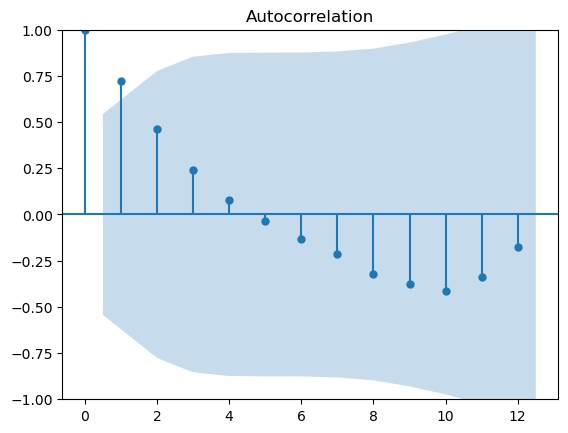

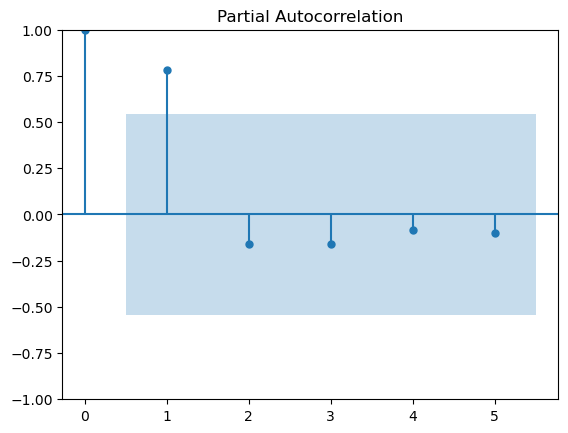

In [61]:
# Preprocess the data to show daily instead of by minute
hourly_data = df.resample('D').mean()
df2 = pd.DataFrame(hourly_data)


print(df2.dropna())
print(len(df2.dropna()))


# ACF plot to determine q value (visu)
plt.figure(figsize=(15, 6))
plot_acf(df2.dropna())
plt.show()

# PACF plot to determine p value 
plot_pacf(df2.dropna(), lags=5)
plt.show()



In [7]:
# 6.1 Determine the best p and q values
# The best p,q,d values will produce the lowest aic value 

import warnings
warnings.filterwarnings("ignore")

# Defines ranges for p and q
p = q = range(0, 4)

# List to store all pdq combinations
pdq = []
# Appends each combination of p,d,q to the list
for p_value in p:
    for q_value in q:
        pdq.append((p_value, d, q_value))

# Initialize best aic to start at infinity
best_aic = float('inf')  
# Initialize best pqd combination 
best_pdq = None

# Test each combination 
for combination in pdq:
    # Fit the arima model 
    model = ARIMA(df, order=(combination))
    model_fit = model.fit()
    
    # If the aic value is lower than the current best aic, it will be replaced
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_pdq = combination

# Extract the p and q values
p = best_pdq[0]
q = best_pdq[2]

print('p value: ', p)
print('q value: ', q)

p value:  2
q value:  3


In [8]:
# 6.2 Create the ARIMA model with the p, d, q values determined
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                12479
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3867.091
Date:                Tue, 16 Jan 2024   AIC                           7746.183
Time:                        10:15:53   BIC                           7790.773
Sample:                             0   HQIC                          7761.112
                              - 12479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5676      0.089     -6.407      0.000      -0.741      -0.394
ar.L2          0.3816      0.097      3.915      0.000       0.191       0.573
ma.L1          0.1209      0.089      1.365      0.1

In [108]:
# 6.3 Train the ARIMA model with the training data and the p, d, q values determined
model = ARIMA(train_data['4. close'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                 8735
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3674.299
Date:                Tue, 16 Jan 2024   AIC                           7360.598
Time:                        01:48:43   BIC                           7403.048
Sample:                             0   HQIC                          7375.065
                               - 8735                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8681      0.095     -9.125      0.000      -1.055      -0.682
ar.L2          0.0896      0.107      0.834      0.404      -0.121       0.300
ma.L1          0.3632      0.095      3.817      0.0

In [109]:
# 7. Make out-of-sample predictions (forecasting)

# fit the model to the DataFrame which includes all of the given data
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()

# make future predictions for extra 30% past the most recent data
forecast_steps = int(len(df) * 0.3)
print("steps: ", forecast_steps)
# use steps parameter for # of future steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)
print("Predicted value:\n", forecast)

steps:  3743
Predicted value:
 12479    218.918003
12480    218.913042
12481    218.909739
12482    218.909723
12483    218.908472
            ...    
16217    218.908664
16218    218.908664
16219    218.908664
16220    218.908664
16221    218.908664
Name: predicted_mean, Length: 3743, dtype: float64
